In [1]:
from langchain.embeddings import LlamaCppEmbeddings
from langchain.llms import LlamaCpp
from langchain.prompts import PromptTemplate
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.chains import LLMChain

import pandas as pd
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

In [ ]:
#Use Llama model for embedding
llama_model_path = '/cis/home/adesilva/ashwin/research/llm-work/llama.cpp/models/7B-chat/ggml-model-q4_0.bin'
embedding_model = LlamaCppEmbeddings(model_path=llama_model_path)

In [ ]:
# Make sure the model path is correct for your system!
callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])
llm = LlamaCpp(
    model_path=llama_model_path,
    temperature=0.75,
    max_tokens=500,
    top_p=1,
    callback_manager=callback_manager, 
    verbose=False, # Verbose is required to pass to the callback manager
)

In [13]:
filepath = '../data/contexts.xlsx'
df = pd.read_excel(filepath)

prompt = """
    Give a precise answer to the question based on the context. Don't be verbose. The answer should be either a yes or a no.
    CONTEXT: {}
    QUESTION: Was R.A. Fisher a great man?
    ANSWER:
    """
num_reps = 10

In [14]:
embeddings = []
outputs = []
labels = []
for i in range(len(df)):
    context = df['string'][i]
    label = 1 if df['label'][i] == 'statistics' else 0
    labels.append(label)
    updated_prompt = prompt.format(context)
    
    embedding = embedding_model.embed_query(updated_prompt)
    embeddings.append(embedding)
    
    outputs_for_prompt = []
    for rep in range(num_reps):
        out = llm(updated_prompt)
        outputs_for_prompt.append(out)
    outputs.append(outputs_for_prompt)

labels = np.array(labels)
embeddings = np.array(embeddings)

In [85]:
binary_outputs = np.zeros((len(outputs), num_reps))
for i in range(len(outputs)):
    for j in range(num_reps):
        out = outputs[i][j].split(',')[0].lstrip().rstrip().replace(".", "")
        if out == 'Yes' or out == 'Yes' or out == 'YES':
            binary_outputs[i, j] = 1
        elif out == ' No' or out == 'No' or out == 'NO' or out == "🙅‍♂️":
            binary_outputs[i, j] = 0
        else:
            break

In [16]:
embeddings = np.load("embeddings.npy")
binary_outputs = np.load("binary_outputs.npy")
labels = np.array(labels)

In [17]:
mds = MDS(n_components=2, normalized_stress='auto')
lowdim_embeddings = mds.fit_transform(embeddings)

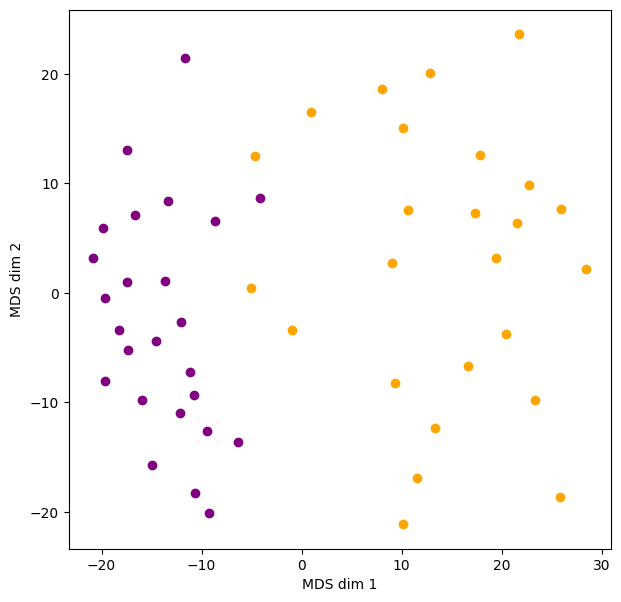

In [83]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(lowdim_embeddings[:, 0][labels == 1], lowdim_embeddings[:, 1][labels == 1], c='purple', label='statistics')
ax.scatter(lowdim_embeddings[:, 0][labels == 0], lowdim_embeddings[:, 1][labels == 0], c='orange', label='eugenics')
ax.set_xlabel("MDS dim 1")
ax.set_ylabel("MDS dim 2")
plt.show()

In [22]:
p = np.mean(binary_outputs, axis=1)

In [55]:
from scipy.interpolate import LinearNDInterpolator, RegularGridInterpolator
from matplotlib import cm

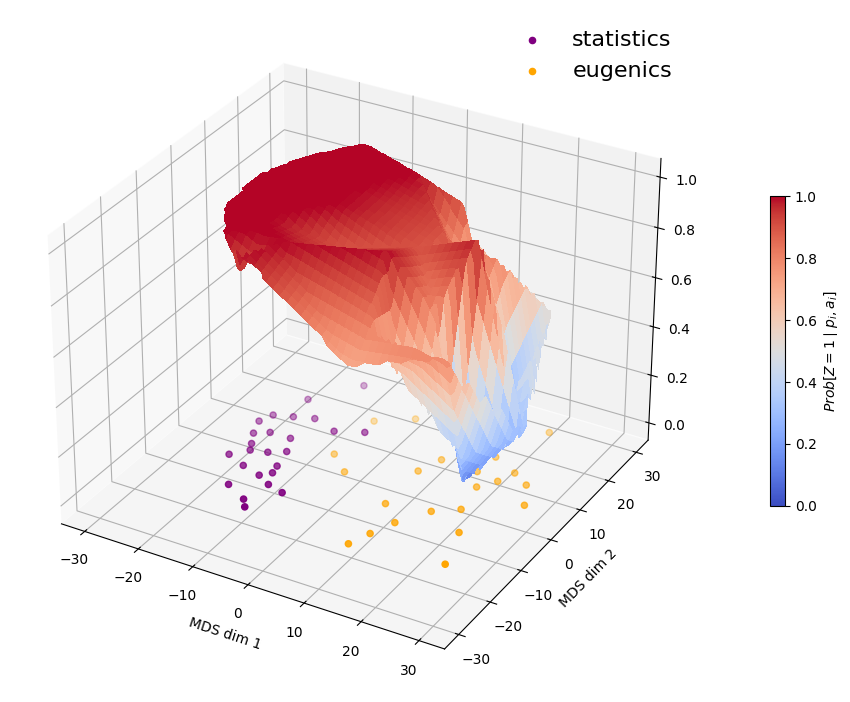

In [100]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

xg, yg = np.meshgrid(lowdim_embeddings[:, 0], lowdim_embeddings[:, 1], indexing='ij')
interp = LinearNDInterpolator((lowdim_embeddings[:, 0], lowdim_embeddings[:, 1]), p)

# ax.scatter(lowdim_embeddings[:, 0], lowdim_embeddings[:, 1], p, color='k')

xx = np.linspace(-30, 30, 100)
yy = np.linspace(-30, 30, 100)
X, Y = np.meshgrid(xx, yy, indexing='ij')

C = ax.plot_surface(X, Y, interp((X, Y)), color='m', cmap=cm.coolwarm, antialiased=False, linewidth=0, vmin=0, vmax=1)

ax.scatter(lowdim_embeddings[:, 0][labels == 1], lowdim_embeddings[:, 1][labels == 1], 0, c='purple', label='statistics')
ax.scatter(lowdim_embeddings[:, 0][labels == 0], lowdim_embeddings[:, 1][labels == 0], 0, c='orange', label='eugenics')

ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

fig.colorbar(C, ax=ax, fraction=0.02, pad=0.1, label=r'$Prob[Z=1 \mid p_i, a_i]$')
ax.legend(frameon=False, fontsize=16)
ax.set_xlabel("MDS dim 1")
ax.set_ylabel("MDS dim 2")

plt.show()